#### Importando as bibliotecas

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import scipy.stats
from scipy.stats import wilcoxon
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_validate
%matplotlib inline


#### Abrindo os dados

In [126]:
data = pd.read_csv(r'D:\Trabalho\faculdade\TCC\outputs\tabelas\dados_treino.csv')
data['data_medicao'] = pd.to_datetime(data['data_medicao'])

#### Criando dados de treinamento

In [150]:
data_copy = data[data['precipitacao']>1]
X = data_copy.set_index(['data_medicao','corredor']).drop(['lentidao',], axis=1)
y = data_copy['lentidao']
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.75)
#x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.7)
#x_val, x_test, y_val, y_test = train_test_split(x_test_and_val,y_test_and_val, train_size=0.5)

#### Criando o modelo

In [151]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

#### Função para gerar métricas  

In [152]:
def get_metrics(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r2_treino = r2_score(y_true, y_pred)
    rmse_treino = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_treino = mean_absolute_percentage_error(y_true,y_pred)

    print(f'R2: {round(r2_treino,2)}')
    print(f'RMSE:{round(rmse_treino,2)}')
    print(f'MAPE: {round(mape_treino,2)}')
    
    fig, ax = plt.subplots(figsize = (8,4))
    ax.scatter(y_true, y_pred)
    a,b,_,_,_ = scipy.stats.linregress(y_true, y_pred)
    ax.plot(np.arange(1,35000), a*np.arange(1,35000)+b, c='r')
    ax.set_title('Actual vs Predicted')
    ax.set_ylabel('predicted slowness')
    ax.set_xlabel('actual slowness')
    #plt.savefig(os.path.join(graficos_dir, 'training_regression.png'))
    plt.show()

Métricas de treino

R2: 0.95
RMSE:954.19
MAPE: 0.19


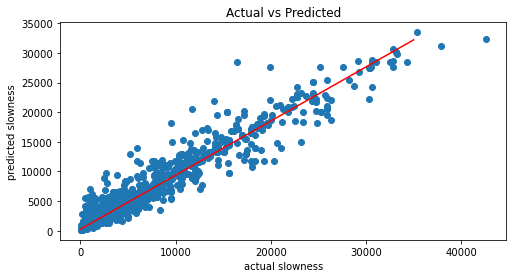

In [153]:
y_pred = model.predict(x_train)
get_metrics(y_train, y_pred)

Métricas de teste

R2: 0.8
RMSE:1949.87
MAPE: 0.44


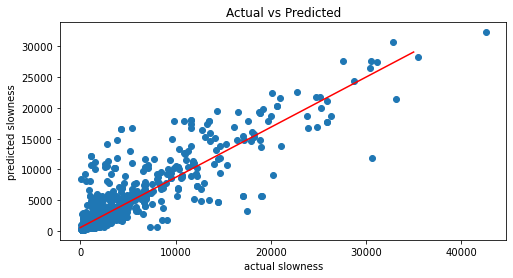

In [154]:
y_pred = model.predict(x_test)
get_metrics(y_test, y_pred)

Importância das features

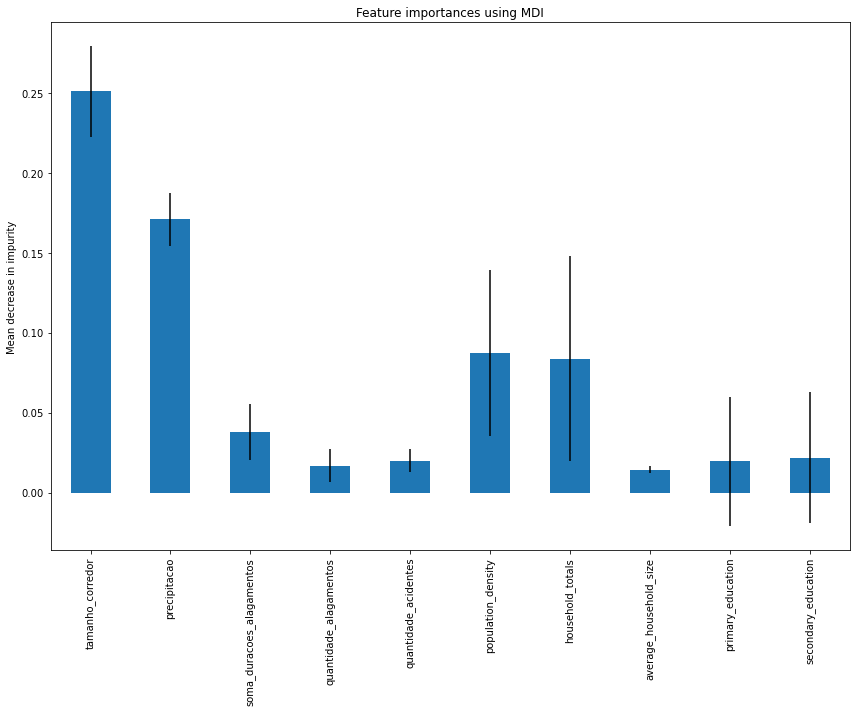

In [155]:
importances = model.feature_importances_
feature_names = x_train.columns
forest_importances = pd.Series(importances, index=feature_names)[:10]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12,10))
forest_importances.plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()